In [1]:
import numpy as np 
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import importlib

import sys
sys.path.append('../util/')
import reader
import composites
importlib.reload(reader)

from tqdm import tqdm, notebook
import xarray as xr
import time
import pickle

In [2]:
# reading in the matlab files for era-interim
folder = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_ERAI.EXP1.TEST.v2.001_2008_2012/etc_composites/tmp/RUNDIR/tmprun/read_tmprun/'
print(os.path.exists(folder))

# reading in a sample model data
mdtf_folder = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_GFDL.EXP1.2PM.v10.001_2008_2012/etc_composites/tmp/RUNDIR/tmprun/read_tmprun/'
print(os.path.exists(mdtf_folder))

# Reading in the topography file
# lm_file = '/localdrive/drive10/jj/mdtf/inputdata/model/ERAI.EXP1.TEST.001/topo.nc'
# lm_file = '/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/topo.nc'
# lm_file = '/localdrive/drive10/jj/mdtf/inputdata/model/ERA5.ALL.DEG15.001/topo.nc'

True
True


In [3]:
importlib.reload(reader)

years = [2008, 2012]
erai_lat = []
erai_lon = []
erai_mm = []
erai_lm_flag = []

# reading in ll of ERA-Interim data
for year in range(years[0], years[1]+1):
    file = os.path.join(folder, f"tmprun_{year}.mat")
    all_centers = reader.read_center_from_mat_file(file)
    lat = all_centers['lat']
    lon = all_centers['lon']
    mm = all_centers['mm']
    lm_flag = all_centers['lm_flag']
    ind = (np.abs(lat) > 30) & (np.abs(lat) < 60)
    lat = lat[ind]
    lon = lon[ind]
    mm = mm[ind]
    lm_flag = lm_flag[ind]
    erai_lat.extend(lat)
    erai_lon.extend(lon)
    erai_mm.extend(mm)
    erai_lm_flag.extend(lm_flag)
    
    print(f"Done processing {year}.")

# reading in a single year of MODEL data
years = [2008, 2008]
mdtf_lat = []
mdtf_lon = []
mdtf_mm = []
for year in range(years[0], years[1]+1):
    file = os.path.join(mdtf_folder, f"tmprun_{year}.mat")
    all_centers = reader.read_center_from_mat_file(file)
    lat = all_centers['lat']
    lon = all_centers['lon']
    mm = all_centers['mm']
    ind = (np.abs(lat) > 30) & (np.abs(lat) < 60)
    lat = lat[ind]
    lon = lon[ind]
    mdtf_lat.extend(lat)
    mdtf_lon.extend(lon)
    mdtf_mm.extend(mm)
    print(f"Done processing {year}.")

Done processing 2008.
Done processing 2009.
Done processing 2010.
Done processing 2011.
Done processing 2012.
Done processing 2008.


In [4]:
print(len(erai_lm_flag))
print(len(erai_lat), len(erai_mm), len(erai_lon))

76874
76874 76874 76874


In [5]:
erai_obs_lat = []
erai_obs_lon = []

# filtering out the lat/lon for the SH Ocean Warm season, and creating the observation distribution
for ilat, ilon, imm, ilm_flag in notebook.tqdm(zip(erai_lat, erai_lon, erai_mm, erai_lm_flag), total=len(erai_lat)):
    # skipping northern hemisphere distribution
    if (ilat > 0): 
        continue
       
    # checking warm season
    if not ((imm == 11) | (imm == 12) | (imm == 1) | (imm == 2) | (imm == 3)):
        continue
        
    # checking ocean (=0), skip if land (=1)
#     dist_grid = composites.compute_dist_from_cdt(reflat, reflon, ilat, ilon)
#     c_ind = np.nanargmin(dist_grid)
#     cx, cy = np.unravel_index(c_ind, dist_grid.shape)
#     lm_flag = lm[cx, cy]
#     if (lm_flag):
#         continue
    
    if (ilm_flag):
        continue
        
    erai_obs_lat.append(ilat)
    erai_obs_lon.append(ilon)
    
    
erai_obs_lat = np.array(erai_obs_lat) 
erai_obs_lon = np.array(erai_obs_lon) 

In [6]:
# ERAI disbribution for the observations (entire collection of cyclones)
bins = np.arange(-60, 60, 5)
erai_lat_ind = np.digitize(erai_lat, bins=bins)
erai_lat_bin_counts = np.bincount(erai_lat_ind, minlength=len(bins)+1)
erai_pct = erai_lat_bin_counts/np.sum(erai_lat_bin_counts)
erai_pct[erai_lat_bin_counts == 0] = np.nan

# ERAI disbribution for the observations(SH Ocean Warm)
erai_obs_lat_ind = np.digitize(erai_obs_lat, bins=bins)
erai_obs_lat_bin_counts = np.bincount(erai_obs_lat_ind, minlength=len(bins)+1)
erai_obs_pct = erai_obs_lat_bin_counts/np.sum(erai_obs_lat_bin_counts)
erai_obs_pct[erai_obs_lat_bin_counts == 0] = np.nan

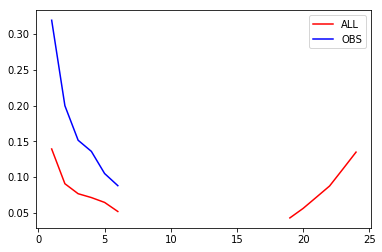

In [7]:
plt.plot(erai_pct, color='r', label='ALL')
plt.plot(erai_obs_pct, color='b', label='OBS')
plt.legend(loc=0)
plt.show()

In [8]:
out = {'all_lat_ind': erai_lat_ind, 'all_bin_counts': erai_lat_bin_counts, 'all_pct': erai_pct,
       'obs_lat_ind': erai_obs_lat_ind, 'obs_bin_counts': erai_obs_lat_bin_counts, 'obs_pct': erai_obs_pct}
out_file = '/localdrive/drive10/jj/mdtf/inputdata/obs_data/etc_composites/erai_lat_distrib.pkl'
pickle.dump(out, open(out_file, 'wb'))

In [233]:
slp_file = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_ERAI.EXP1.TEST.001_2008_2012/etc_composites/tmp/data_converts/slp.2008.nc'
slp = xr.open_dataset(slp_file)
reflat = slp.lat.values
reflon = slp.lon.values

reflon, reflat = np.meshgrid(reflon, reflat)

print(lm_file)
ds = xr.open_dataset(lm_file)
lm = ds.lsm.values
lm = (lm > 50./100.)

/localdrive/drive10/jj/mdtf/inputdata/model/GFDL.EXP1.2PM.001/topo.nc


In [235]:
print(erai_obs_lat.shape)
print(erai_obs_lon.shape)

(16816,)
(16816,)


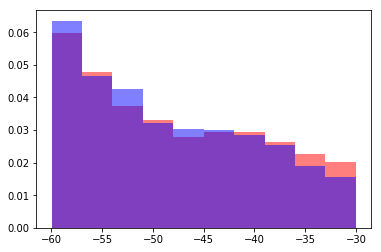

In [236]:
plt.hist(erai_obs_lat, density=True, alpha=0.5, color='r')
tmp = np.array(mdtf_lat)
plt.hist(tmp[tmp<0], density=True, alpha=0.5, color='b')
plt.show()

/home/jj/anaconda3/envs/mcms/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


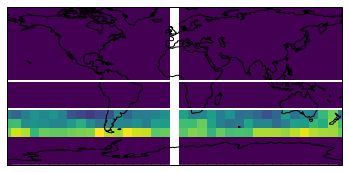

In [237]:
import cartopy
from cartopy.util import add_cyclic_point

plt.figure()
ax = plt.subplot(projection=cartopy.crs.PlateCarree())
H, x, y = np.histogram2d(erai_obs_lon, erai_obs_lat, bins=(np.arange(0, 360, 10), np.arange(-90, 90, 10)))
H = H.T
lon = x[:-1] + 5
lat = y
H, lon = add_cyclic_point(H, coord=lon)
ax.pcolormesh(lon, lat, H)
ax.coastlines(color='k')
ax.plot([-180, 180], [0, 0], color='w', lw=2.)
ax.plot([-180, 180], [-30, -30], color='w', lw=2.)
plt.show()

In [238]:
# ERAI disbribution for the observations (entire collection of cyclones)
bins = np.arange(-60, 60, 5)
erai_lat_ind = np.digitize(erai_lat, bins=bins)
erai_lat_bin_counts = np.bincount(erai_lat_ind, minlength=len(bins)+1)
erai_pct = erai_lat_bin_counts/np.sum(erai_lat_bin_counts)
erai_pct[erai_lat_bin_counts == 0] = np.nan

# ERAI disbribution for the observations(SH Ocean Warm)
erai_obs_lat_ind = np.digitize(erai_obs_lat, bins=bins)
erai_obs_lat_bin_counts = np.bincount(erai_obs_lat_ind, minlength=len(bins)+1)
erai_obs_pct = erai_obs_lat_bin_counts/np.sum(erai_obs_lat_bin_counts)
erai_obs_pct[erai_obs_lat_bin_counts == 0] = np.nan

# MDTF distribution of cyclones
mdtf_lat_ind = np.digitize(mdtf_lat, bins=bins)
mdtf_lat_bin_counts = np.bincount(mdtf_lat_ind, minlength=len(bins)+1)
mdtf_pct = mdtf_lat_bin_counts/np.sum(mdtf_lat_bin_counts)
mdtf_pct[mdtf_lat_bin_counts == 0] = np.nan

print(erai_lat_bin_counts)
print(erai_obs_lat_bin_counts)
print(mdtf_lat_bin_counts)

[    0 10716  6979  5906  5493  4971  3996     0     0     0     0     0
     0     0     0     0     0     0     0  3305  4325  5526  6734  8545
 10378]
[   0 4738 3068 2570 2514 2148 1778    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
[   0 2040 1460 1097 1061  881  589    0    0    0    0    0    0    0
    0    0    0    0    0  474  741 1115 1401 1689 1869]


In [239]:
diff_pct = erai_obs_pct - mdtf_pct
max_ind = np.nanargmax(diff_pct)
max_mdtf_count = mdtf_lat_bin_counts[max_ind] 

print(diff_pct)
print(max_ind, mdtf_count)

max_mdtf_count = max_mdtf_count/erai_obs_pct[max_ind]
print(max_mdtf_count)

tmp = np.copy(mdtf_pct)
tmp[np.isnan(erai_obs_pct)] = np.nan
diff_pct = erai_obs_pct - mdtf_pct
min_ind = np.nanargmin(tmp)
min_mdtf_count = mdtf_lat_bin_counts[min_ind] 

print(min_ind, min_mdtf_count, mdtf_pct, erai_obs_pct)
min_mdtf_count = min_mdtf_count/erai_obs_pct[min_ind]


[       nan 0.14025585 0.08117596 0.07673991 0.0759068  0.06662708
 0.06487809        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
1 2040
7240.320810468553
6 589 [       nan 0.14149962 0.10126933 0.07609073 0.07359367 0.06110841
 0.04085455        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.03287785 0.05139766 0.07733925 0.09717694 0.11715336
 0.12963862] [       nan 0.28175547 0.18244529 0.15283064 0.14950048 0.12773549
 0.10573264        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
[-9223372036854775808                  788                  564
                  423                  409                  34

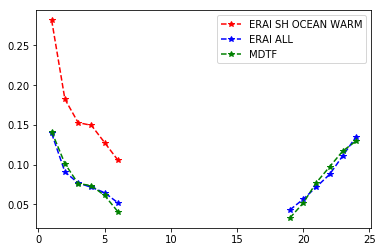

In [240]:
plt.plot(erai_obs_pct, 'r*--', label='ERAI SH OCEAN WARM')
plt.plot(erai_pct, 'b*--', label='ERAI ALL')
plt.plot(mdtf_pct, 'g*--', label='MDTF')
plt.legend(loc=0)
plt.show()

19 0.0328778525352015 474 11025.196974281393


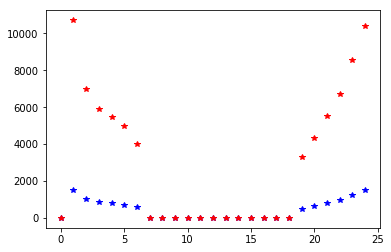

In [241]:
# Selecting all the MDTF cases by the total_distrib
mdtf_min_ind = np.nanargmin(mdtf_pct)
mdtf_min = mdtf_pct[mdtf_min_ind]
mdtf_min_count = mdtf_lat_bin_counts[mdtf_min_ind]
erai_min_pct = erai_pct[mdtf_min_ind]

total_mdtf_count = mdtf_min_count/erai_min_pct
print(mdtf_min_ind, mdtf_min, mdtf_min_count, total_mdtf_count)

new_distrib = erai_pct * total_mdtf_count
new_distrib[np.isnan(new_distrib)] = 0
new_distrib = np.array(new_distrib, dtype=np.int)

# print(erai_lat_bin_counts)
# print(mdtf_lat_bin_counts)
# print(new_distrib)

plt.plot(new_distrib, 'b*')
plt.plot(erai_lat_bin_counts, 'r*')

19 0.0328778525352015 474 nan
[   0 1111  690  528  456  434  224    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[   0 2040 1460 1097 1061  881  589    0    0    0    0    0    0    0
    0    0    0    0    0  474  741 1115 1401 1689 1869]
[   0 1536 1000  847  787  712  573    0    0    0    0    0    0    0
    0    0    0    0    0  474  620  792  965 1225 1488]


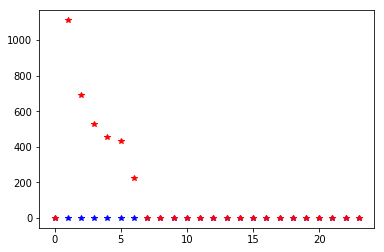

In [207]:
# Selecting all the MDTF cases by the total_distrib
mdtf_min_ind = np.nanargmin(mdtf_pct)
mdtf_min = mdtf_pct[mdtf_min_ind]
mdtf_min_count = mdtf_lat_bin_counts[mdtf_min_ind]
erai_obs_min_pct = erai_obs_pct[mdtf_min_ind]

total_mdtf_count = mdtf_min_count/erai_obs_min_pct
print(mdtf_min_ind, mdtf_min, mdtf_min_count, total_mdtf_count)

new_obs_distrib = erai_obs_pct * total_mdtf_count
new_obs_distrib[np.isnan(new_obs_distrib)] = 0
new_obs_distrib = np.array(new_obs_distrib, dtype=np.int)

print(erai_obs_lat_bin_counts)
print(mdtf_lat_bin_counts)
print(new_distrib)

plt.plot(new_obs_distrib, 'b*')
plt.plot(erai_obs_lat_bin_counts, 'r*')
plt.show()

# Saving the ERAI information cyclone distribution, I have to match this to the model 

In [125]:
# out = {'all_lat_ind': erai_lat_ind, 'all_bin_counts': erai_lat_bin_counts, 'all_pct': erai_pct,
#        'obs_lat_ind': erai_obs_lat_ind, 'obs_bin_counts': erai_obs_lat_bin_counts, 'obs_pct': erai_obs_pct}
# out_file = '/localdrive/drive10/jj/mdtf/inputdata/obs_data/etc_composites/erai_lat_distrib.pkl'
# pickle.dump(out, open(out_file, 'wb'))

# Some online method to sub-sample datasets

In [93]:
weights = 1 / np.array([lat_bin_counts[x] for x in lat_ind])
# weights_norm = weights / np.sum(weights)

mdtf_weights = 1 / np.array([lat_bin_counts[x] for x in mdtf_lat_ind])
# mdtf_weights_norm = mdtf_weights / np.sum(mdtf_weights)

In [94]:
np.random.seed(0)
SAMPLE_SIZE = len(mdtf_lat)
sample = np.random.choice(mdtf_lat, size=SAMPLE_SIZE, p=mdtf_weights_norm, replace=False)

In [97]:
sample_lat_ind = np.digitize(sample, bins=np.arange(-60, 60, 5))
sample_lat_bin_counts = np.bincount(sample_lat_ind)
sample_lat_bin_counts = sample_lat_bin_counts/np.sum(sample_lat_bin_counts)

In [98]:

print(lat_bin_counts, mdtf_lat_bin_counts, sample_lat_bin_counts)

[0.         0.13939694 0.09078492 0.07682702 0.07145459 0.06466426
 0.05198116 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.04299243 0.05626089 0.07188386 0.08759789 0.11115592
 0.13500013] [0.         0.15769997 0.1104198  0.08719992 0.07550188 0.05900533
 0.04235967 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02613422 0.04877123 0.07246554 0.08661706 0.11028425
 0.12354113] [0.         0.15769997 0.1104198  0.08719992 0.07550188 0.05900533
 0.04235967 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02613422 0.04877123 0.07246554 0.08661706 0.11028425
 0.12354113]


(array([20306., 12900.,  4855.,     0.,     0.,     0.,     0.,  4153.,
        12678., 21982.]),
 array([-5.9980e+01, -4.7983e+01, -3.5986e+01, -2.3989e+01, -1.1992e+01,
         5.0000e-03,  1.2002e+01,  2.3999e+01,  3.5996e+01,  4.7993e+01,
         5.9990e+01]),
 <a list of 10 Patch objects>)

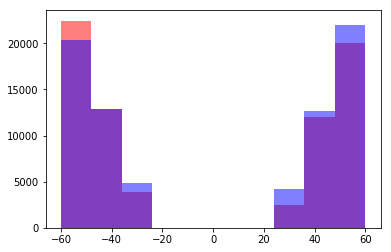

In [81]:
plt.hist(sample, color='r', alpha=0.5)
plt.hist(all_lat, color='b', alpha=0.5)

15212 73773


(array([0.02592136, 0.01392225, 0.00393395, 0.        , 0.        ,
        0.        , 0.        , 0.0027724 , 0.01428387, 0.02251339]),
 array([-59.99 , -47.992, -35.994, -23.996, -11.998,   0.   ,  11.998,
         23.996,  35.994,  47.992,  59.99 ]),
 <a list of 10 Patch objects>)

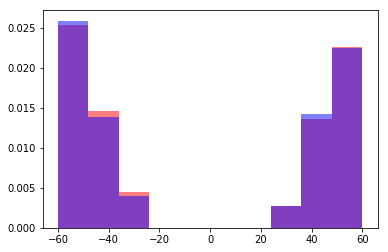

In [71]:
print(len(lat), len(mdtf_lat))
plt.hist(mdtf_lat, density=True, color='r', alpha=0.5)
plt.hist(lat, density=True, color='b', alpha=0.5)

In [135]:
np.random.seed(0)
SAMPLE_SIZE = len(mdtf_lat)
sample = np.random.choice(mdtf_lat, size=SAMPLE_SIZE, p=weights_norm, replace=False)

NameError: name 'weights_norm' is not defined

In [165]:
import random
tmp = random.sample(np.arange(0, len(all_centers['all_select_flag'])).tolist(), 1009900)

ValueError: Sample larger than population or is negative

In [162]:
x = np.copy(all_centers['obs_select_flag'])
x[tmp] = 1

In [163]:
np.sum(x)

10.0